In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/janestreet/data.parquet
/kaggle/input/janestreet-parquet/train.parquet


# I. Project Overview

## 1. Overview

“Buy low, sell high.” It sounds so easy….

In reality, trading for profit has always been a difficult problem to solve, even more so in today’s fast-moving and complex financial markets. Electronic trading allows for thousands of transactions to occur within a fraction of a second, resulting in nearly unlimited opportunities to potentially find and take advantage of price differences in real time.

In a perfectly efficient market, buyers and sellers would have all the agency and information needed to make rational trading decisions. As a result, products would always remain at their “fair values” and never be undervalued or overpriced. However, financial markets are not perfectly efficient in the real world.

Developing trading strategies to identify and take advantage of inefficiencies is challenging. Even if a strategy is profitable now, it may not be in the future, and market volatility makes it impossible to predict the profitability of any given trade with certainty. As a result, it can be hard to distinguish good luck from having made a good trading decision.

## 2. Data description

This dataset contains an anonymized set of features, feature_{0...129}, representing real stock market data. Each row in the dataset represents a trading opportunity, for which I will be predicting an action value: 1 to make the trade and 0 to pass on it. Each trade has an associated weight and resp, which together represents a return on the trade. The date column is an integer which represents the day of the trade, while ts_id represents a time ordering.

Trades with weight = 0 were intentionally included in the dataset for completeness, although such trades will not contribute towards the scoring evaluation.

# II. Problem Statement

The challenge will be to use the historical data, mathematical tools, and technological tools at one's disposal to create a model that gets as close to certainty as possible. One will be presented with many potential trading opportunities, which their model must choose whether to accept or reject.

In this notebook, I will try to explore the problem from a classification perspective.

# III. Metrics


This problem is evaluated on a utility score. Each row in the test set represents a trading opportunity for which I will be predicting an action value, 1 to make the trade and 0 to pass on it. Each trade j has an associated weight and resp, which represents a return.


$$
p_i = \sum_j(weight_{ij} * resp_{ij} * action_{ij}),
$$

$$
t = \frac{\sum p_i }{\sqrt{\sum p_i^2}} * \sqrt{\frac{250}{|i|}},
$$

where \(|i|\) is the number of unique dates in the test set. The utility is then defined as:

$$ u = min(max(t,0), 6) \sum p_i. $$


# IV. Data Preprocessing

## 1. Loading data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import gc  

In [3]:
# this data is already excluded day <= 85
data = pd.read_parquet('../input/janestreet/data.parquet')
data.head()


,date,weight,resp_1,resp_2,resp_3,resp_4,resp,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,feature_79,feature_80,feature_81,feature_82,feature_83,feature_84,feature_85,feature_86,feature_87,feature_88,feature_89,feature_90,feature_91,feature_92,feature_93,feature_94,feature_95,feature_96,feature_97,feature_98,feature_99,feature_100,feature_101,feature_102,feature_103,feature_104,feature_105,feature_106,feature_107,feature_108,feature_109,feature_110,feature_111,feature_112,feature_113,feature_114,feature_115,feature_116,feature_117,feature_118,feature_119,feature_120,feature_121,feature_122,feature_123,feature_124,feature_125,feature_126,feature_127,feature_128,feature_129,ts_id
0,86,0.859516,-0.003656,-0.005449,-0.017403,-0.028896,-0.021435,1,3.151305,5.467693,-0.164505,-0.189219,0.663966,0.988896,NaN,NaN,2.184804,3.278742,NaN,NaN,1.471544,2.391430,1.640887,3.938759,NaN,NaN,2.361346,4.711640,NaN,NaN,1.958027,4.069699,2.535238,4.813858,NaN,NaN,-0.194392,-0.336857,NaN,NaN,-0.073242,-0.131142,-0.197839,-0.288336,0.341815,0.599994,-0.202268,-0.471068,-0.405654,0.052440,-1.349263,-0.633717,-0.796947,-0.381209,-0.542896,-0.166690,0.222588,-0.554461,-0.187021,-0.551972,2.589171,4.141244,NaN,-0.414845,-1.150279,-0.908903,-1.341168,-1.325681,-1.110222,-1.656347,-1.810199,-4.434427,-1.661965,-1.101438,-2.136155,-2.048593,2.649794,3.595955,4.039769,NaN,-1.254960,NaN,-0.763423,-1.204365,0.649855,NaN,-0.374423,NaN,-0.335769,-0.345847,0.386626,NaN,-1.238212,NaN,-2.321156,-1.641860,-2.060506,NaN,-1.515613,NaN,-1.746285,-1.086886,-3.388070,NaN,1.607253,NaN,0.199793,0.969663,-2.434601,NaN,0.227364,NaN,-0.633981,-0.122468,-4.349793,NaN,0.322244,NaN,-0.458309,-0.032740,-3.018269,NaN,-1.219454,NaN,-2.608786,-1.611309,-2.724954,NaN,NaN,2.433699,4.282284,1.621115,4.331030,2.553220,3.799011,2.642943,3.998054,527894
1,86,0.000000,-0.009107,-0.013542,-0.022222,-0.032522,-0.026394,1,2.249176,2.618401,-0.304355,-0.276975,-0.035921,-0.036215,NaN,NaN,3.354857,3.040463,NaN,NaN,2.365050,2.376956,2.337125,3.438553,NaN,NaN,3.041641,4.165903,NaN,NaN,2.889146,4.174374,3.234317,4.276899,NaN,NaN,-1.644735,-2.479335,NaN,NaN,-1.321317,-1.491122,-2.478752,-2.496164,0.396227,0.435508,-0.248213,-0.439213,-0.993568,3.075146,0.017041,-1.907786,-1.643755,-0.873190,-0.730260,-0.627203,-0.498971,-2.203055,-1.725478,-2.086345,2.184227,-0.152785,NaN,-0.687010,-1.775500,-1.508644,-1.546806,-1.248566,-1.045781,-1.892714,-2.131570,-4.407797,-1.720470,-1.133543,-2.126616,-2.039426,3.591019,1.079669,3.550142,NaN,-1.871530,NaN,-1.154754,-1.803521,-0.008046,NaN,-0.198914,NaN,-0.167805,-0.182515,0.164888,NaN,-1.238212,NaN,-2.321156,-1.641860,-2.579694,NaN,-1.515613,NaN,-1.746285,-1.086886,-4.781603,NaN,2.557578,NaN,0.665543,1.704761,-1.965635,NaN,-0.079505,NaN,-0.857492,-0.512759,-4.546557,NaN,1.275872,NaN,-0.054892,0.872509,-3.120828,NaN,-1.881751,NaN,-3.280218,-2.261787,-3.617442,NaN,NaN,2.053416,-0.493276,1.661974,-1.082122,2.427706,-0.756115,2.210572,-0.639075,527895
2,86,0.590949,0.000347,-0.000376,-0.004051,-0.007995,-0.004743,-1,-0.365888,0.824004,-0.293208,-0.416391,-0.599185,-0.997330,NaN,NaN,-0.869330,0.174646,NaN,NaN,-2.376733,-2.602154,-0.580833,0.145479,NaN,NaN,-0.440224

In [4]:
data.shape

(1862597, 138)

## 2. Preprocessing Data

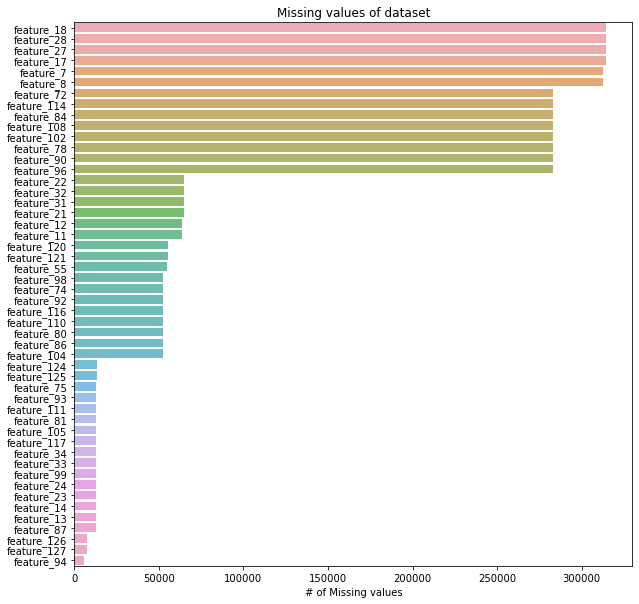

In [5]:
# check null data
data_null = data.isna().sum().to_frame(name = 'Null values')
data_null = data_null[data_null['Null values']>0]
data_null.sort_values(by='Null values', ascending = False, inplace = True)

fig, axs = plt.subplots(figsize=(10, 10))
sns.barplot(y = data_null.index[:50], 
            x = data_null['Null values'][:50], 
            alpha = 0.8
            )
plt.title('Missing values of dataset')
plt.xlabel('# of Missing values')
plt.show()

In [6]:
# Number of features have null values:
data_null.shape[0]

88

In [7]:
# check null values of 'resp' column:
data['resp'].isnull().any().any()

False

Trades with weight = 0 were intentionally included in the dataset for completeness, although such trades will not contribute towards the scoring evaluation.

In [8]:
print(f"Percentage of zero weights is: {((sum(data['weight'] == 0))/len(data))*100}%")

Percentage of zero weights is: 15.633118704690279%


We observe that percentage of zero weights is 15.6%, and since these weights would not contribute to towards scoring evaluation, we can drop them.

In [9]:
# Select trade with weight !=  0:
data = data[data['weight'] != 0]


In [10]:

# limit memory use: we change datatype from float64 to float32
data = data.astype({c: np.float32 for c in data.select_dtypes(include='float64').columns}) 

# create target variable
data['action'] = (data['resp'] > 0).astype('int')

# fill null values with mean of each feature
data.fillna(data.mean(),inplace=True)

#create fetures list
features = [c for c in data.columns if 'feature' in c]



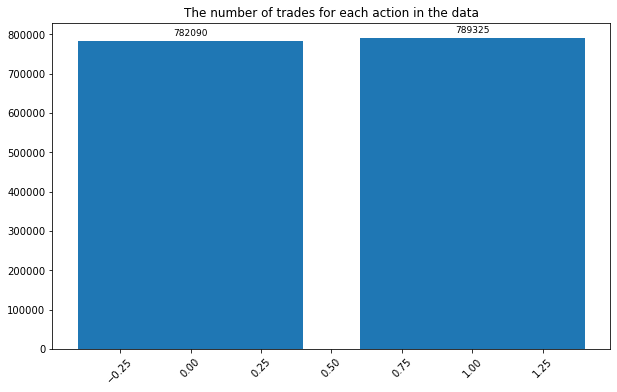

In [11]:
# Check data imbalance:

fig, ax = plt.subplots(figsize = (10,6))
ax.bar(data['action'].value_counts().index,data['action'].value_counts())
ax.set_title('The number of trades for each action in the data')
plt.xticks(rotation = 45)
for bar in ax.patches: 
    
  # Using Matplotlib's annotate function and 
  # passing the coordinates where the annotation shall be done 
  # x-coordinate: bar.get_x() + bar.get_width() / 2 
  # y-coordinate: bar.get_height() 
  # free space to be left to make graph pleasing: (0, 8) 
  # ha and va stand for the horizontal and vertical alignment 
  ax.annotate(bar.get_height(),  
                   (bar.get_x() + bar.get_width() / 2,  
                    bar.get_height()), ha='center', va='center', 
                   size=9, xytext=(0, 8), 
                   textcoords='offset points') 
plt.show()

# V. Implementation

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import PredefinedSplit
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline


In [13]:

#create train, valid, test data:
train_valid, test = train_test_split(data, test_size = 0.2, random_state = 42, shuffle=False)
X_train, X_valid, y_train, y_valid = train_test_split(train_valid[features], train_valid['action'],
                                                      test_size = 0.2, random_state = 42, shuffle=False)


In [14]:
# Create a list where train data indices are -1 and validation data indices are 0
split_index = [-1 if x in X_train.index else 0 for x in train_valid.index]

valid_fold = PredefinedSplit(test_fold=split_index)

In [15]:
del data, data_null

In [16]:
gc.collect()

58

## 1. Try logistic regression

In [17]:
%%time

# Create the model
logis = LogisticRegression()
# Create tuning parameters
parameters = {'solver':('newton-cg', 'lbfgs', 'sag'), 'C':[0.1,1, 10]}
# Create GridSearchCV
grid_search = GridSearchCV(logis, parameters, cv = valid_fold, verbose = 10)
# Train the model
pipeline = make_pipeline(StandardScaler(), grid_search) # create a pipeline for scaling data before training
model = pipeline.fit(train_valid[features], train_valid['action'])
best_est = grid_search.best_estimator_
prediction = best_est.predict(test[features])
print(grid_search.best_params_)

Fitting 1 folds for each of 9 candidates, totalling 9 fits
[CV 1/1; 1/9] START C=0.1, solver=newton-cg.....................................
[CV 1/1; 1/9] END ...................C=0.1, solver=newton-cg; total time= 5.0min
[CV 1/1; 2/9] START C=0.1, solver=lbfgs.........................................


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV 1/1; 2/9] END .......................C=0.1, solver=lbfgs; total time=  41.7s
[CV 1/1; 3/9] START C=0.1, solver=sag...........................................


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV 1/1; 3/9] END .........................C=0.1, solver=sag; total time= 3.2min
[CV 1/1; 4/9] START C=1, solver=newton-cg.......................................
[CV 1/1; 4/9] END .....................C=1, solver=newton-cg; total time= 5.3min
[CV 1/1; 5/9] START C=1, solver=lbfgs...........................................


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV 1/1; 5/9] END .........................C=1, solver=lbfgs; total time=  41.6s
[CV 1/1; 6/9] START C=1, solver=sag.............................................


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV 1/1; 6/9] END ...........................C=1, solver=sag; total time= 3.2min
[CV 1/1; 7/9] START C=10, solver=newton-cg......................................
[CV 1/1; 7/9] END ....................C=10, solver=newton-cg; total time= 5.3min
[CV 1/1; 8/9] START C=10, solver=lbfgs..........................................


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV 1/1; 8/9] END ........................C=10, solver=lbfgs; total time=  39.9s
[CV 1/1; 9/9] START C=10, solver=sag............................................


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV 1/1; 9/9] END ..........................C=10, solver=sag; total time= 3.2min


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


{'C': 1, 'solver': 'sag'}
CPU times: user 30min 57s, sys: 19.2 s, total: 31min 16s
Wall time: 31min 16s


### Classification report

In [18]:
print("\n\n",classification_report(test['action'], prediction))



               precision    recall  f1-score   support

           0       0.52      0.51      0.51    157649
           1       0.51      0.52      0.51    156634

    accuracy                           0.51    314283
   macro avg       0.51      0.51      0.51    314283
weighted avg       0.51      0.51      0.51    314283



### AUC score

In [19]:
from sklearn.metrics import roc_auc_score

roc_auc_score(test['action'].values, best_est.predict_proba(test[features])[:,1])

0.5218034793572293

### Utility score

In [20]:
result_df = pd.DataFrame({'Date': test['date'], 'Weight': test['weight'], 'Resp': test['resp'], 'Action': prediction} )
result_df['P'] = result_df['Weight']*result_df['Resp']*result_df['Action']
result_df.head()

,Date,Weight,Resp,Action,P
1493256,430,0.195581,0.032779,1,0.006411
1493257,430,11.982266,-0.004582,0,-0.000000
1493258,430,1.107787,-0.004491,1,-0.004975
1493259,430,1.312454,0.000542,0,0.000000
1493260,430,0.422074,-0.004623,0,-0.000000


In [21]:
result_groupby_days = result_df[['Date', 'P']].groupby('Date').sum().reset_index()
print(result_groupby_days.shape)
result_groupby_days.head()

(70, 2)


,Date,P
0,430,2.225320
1,431,-1.971770
2,432,1.788491
3,433,-16.939428
4,434,1.787743


In [22]:
p = result_groupby_days['P'].values

t = (np.sum(p)/(np.sqrt(np.sum(p**2))))*np.sqrt(250/len(p))

u = min(max(t, 0), 6) * np.sum(p)

print(f"Utility score is: {u:.3f}")

Utility score is: 934.055


In [24]:
# result_df[['Date', 'Action']].to_csv('Logis_result.csv')